In [1]:
%matplotlib notebook
import numpy as np
import sigpy.plot as pl
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

<h1> Time to Peak Color Map Project<h1>

In [2]:
#Load and deserialize numpy array 
mat = np.load("20190923_vo1_pr_rec_Jac_fit_workspace.npy", allow_pickle=True).item()
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'D', 'Jac', 'Jac_fit', 'Jac_max', 'insp_reg', 'invD', 'lung_mask'])

<IPython.core.display.Javascript object>


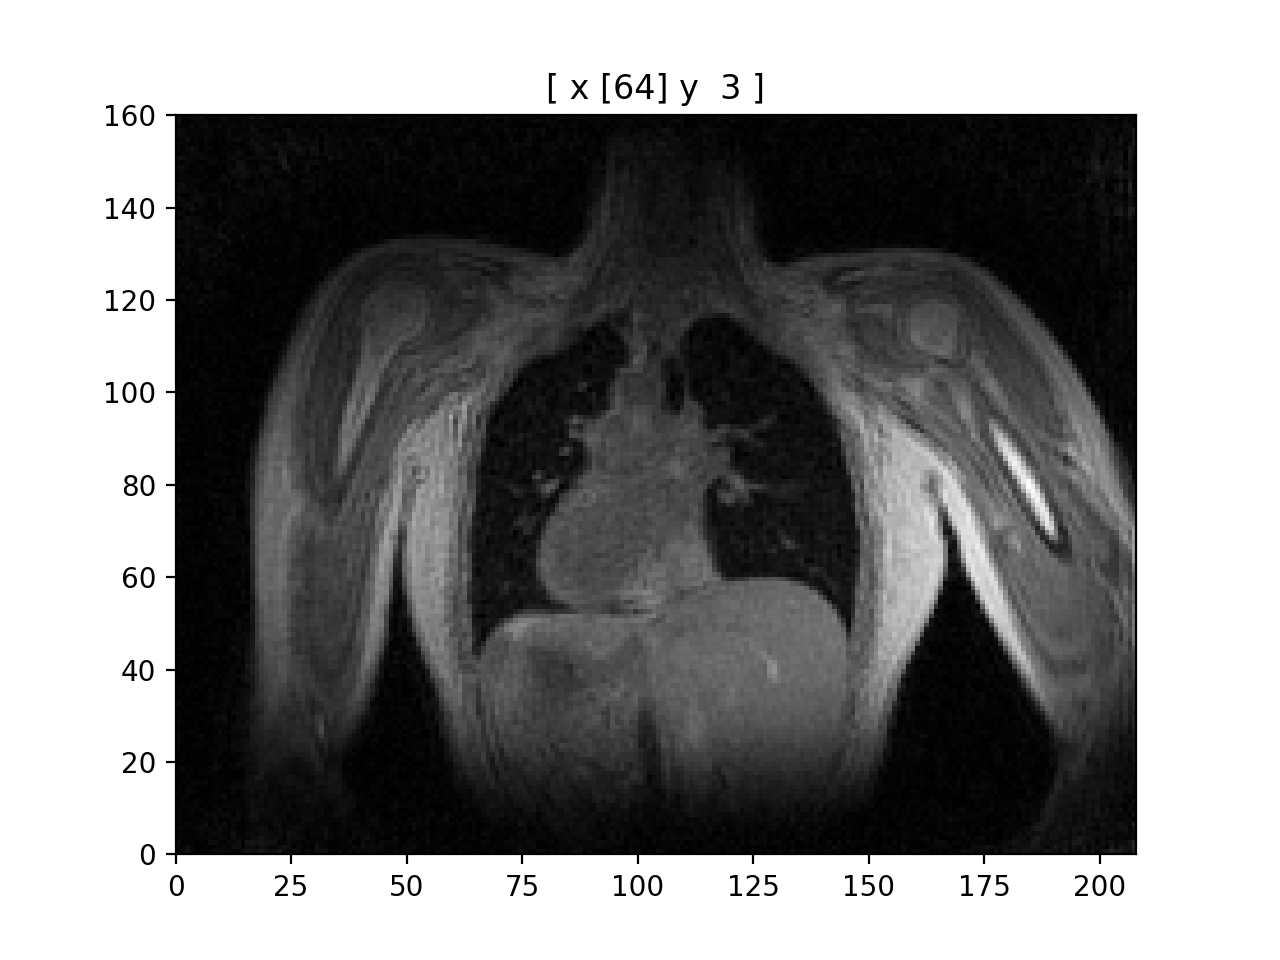

In [3]:
#Plot registered MRI image
registered = mat['insp_reg']
pl.ImagePlot(registered, x=0)

<h1> Curve Fitting for Time to Peak <h1>

In [4]:
#Computes lagrange polynomial values in [0,5]
def lagrange_curve_fitting(y_values, samples):
    lagrange_x = np.linspace(0,5,6)
    lagrange_y = y_values
    x = np.linspace(0,5,num=samples)
    poly = lagrange(lagrange_x, lagrange_y)
    lagrange_coef = Polynomial(poly).coef
    
    return x, poly(x)

In [5]:
#Plot time to peak intensity with lagrange curve fit 
def plot_TTP_langrange(intensity_values):
    lagrange_x, lagrange_y = lagrange_curve_fitting(intensity_values, 40)
    fig = plt.figure()
    plt.plot(np.arange(6), intensity_values, label='Intensity')
    plt.plot(lagrange_x, lagrange_y, label='Lagrange Polynomial')
    plt.title('Time to Peak')
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


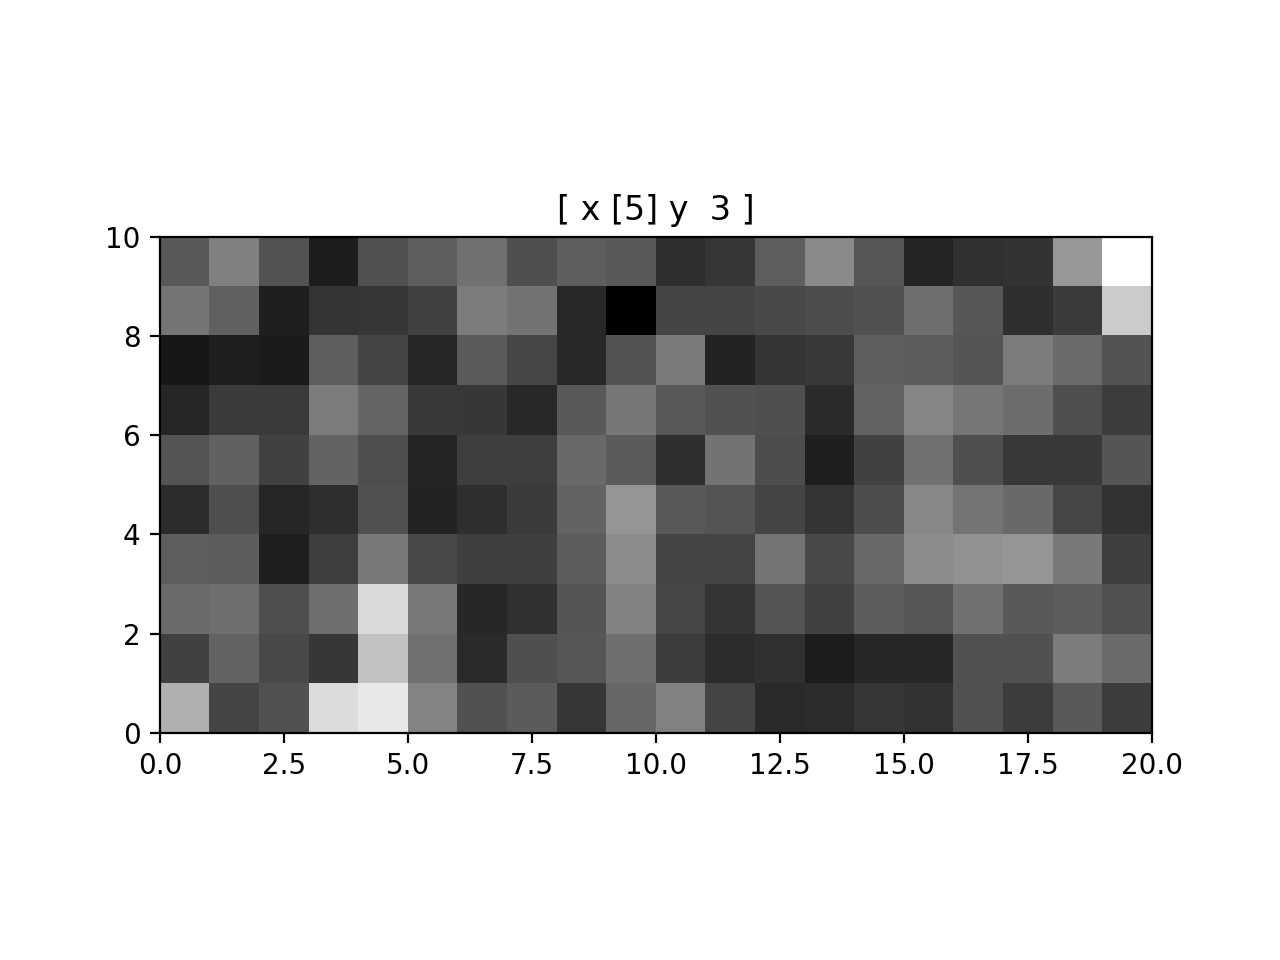

In [6]:
#Sample of the top right lung
intensity_top = registered[115:135,60:70,95:105,:]
pl.ImagePlot(intensity_top, x=0)

In [7]:
#Calculate intensity of top right lung image
intensity_top_array = []
for i in range(intensity_top.shape[3]):
    intensity_top_array = np.append(intensity_top_array, np.mean(intensity_top[:,:,:,i:i+1]))

print(intensity_top_array)

[0.01820932 0.01875403 0.01853799 0.01853428 0.01831131 0.01790099]


<IPython.core.display.Javascript object>


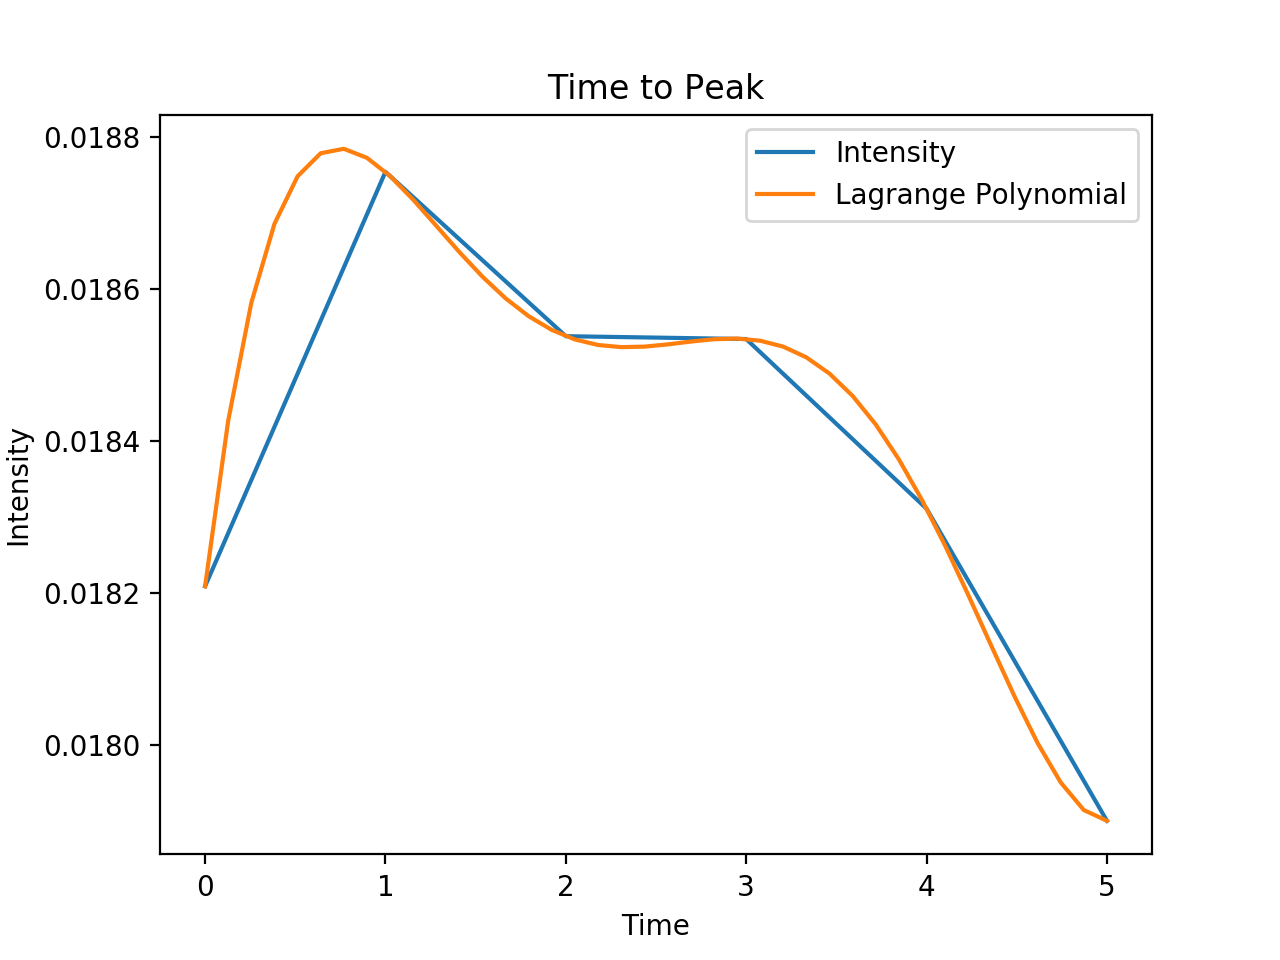

In [8]:
#Plot Time to Peak of top right sample
plot_TTP_langrange(intensity_top_array)

<IPython.core.display.Javascript object>


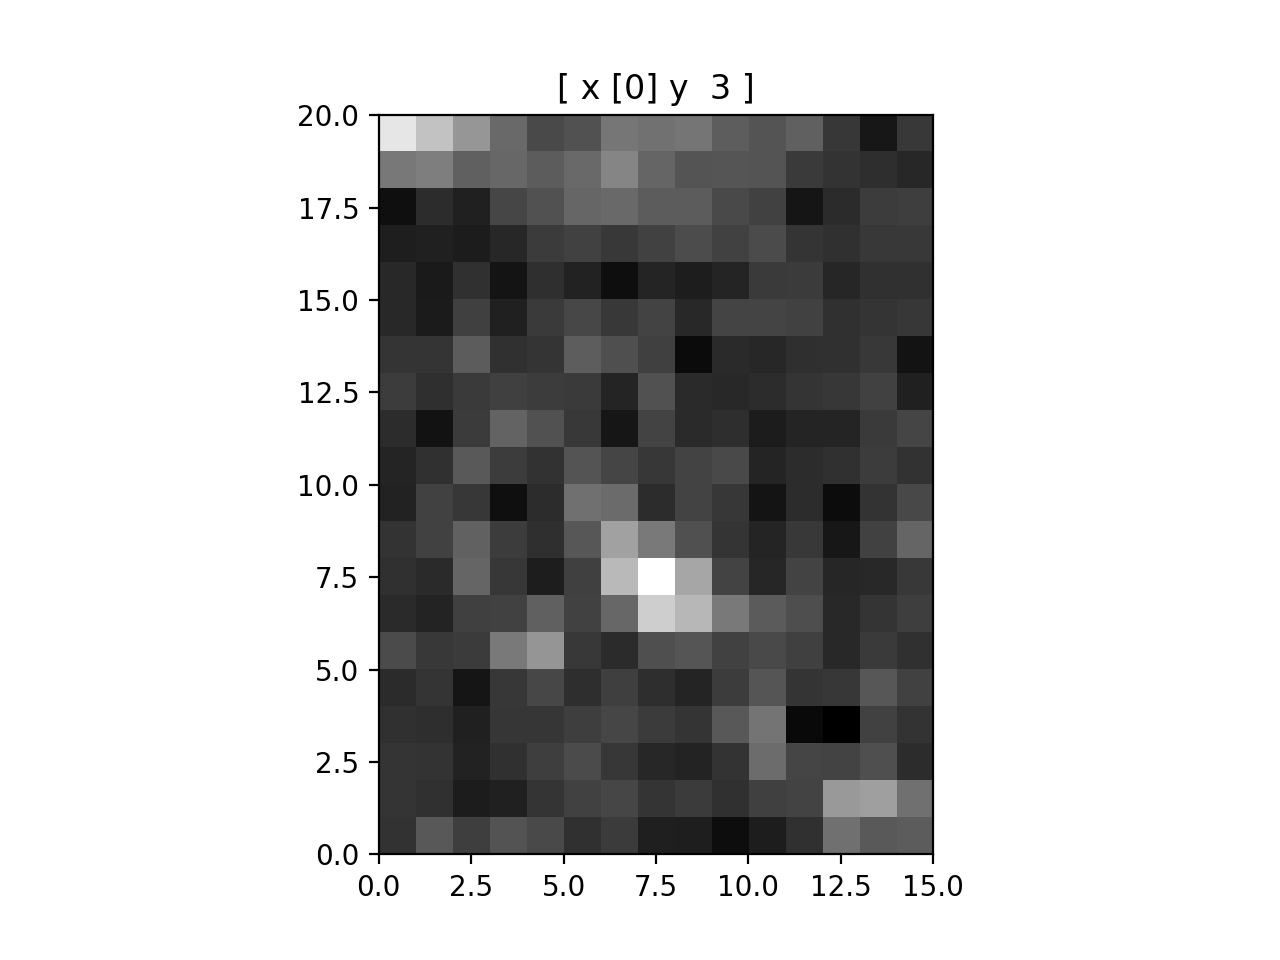

In [9]:
#Sample of the bottom right lung
intensity_bottom = registered[125:140,64:65,60:80,:]
pl.ImagePlot(intensity_bottom, x=0)

In [10]:
#Calculate intensity of bottom right lung image
intensity_bottom_array = []
for i in range(intensity_bottom.shape[3]):
    intensity_bottom_array = np.append(intensity_bottom_array, np.mean(intensity_bottom[:,:,:,i:i+1]))

print(intensity_bottom_array)

[0.02487108 0.02563264 0.02585534 0.02560169 0.02506601 0.02471635]


<IPython.core.display.Javascript object>


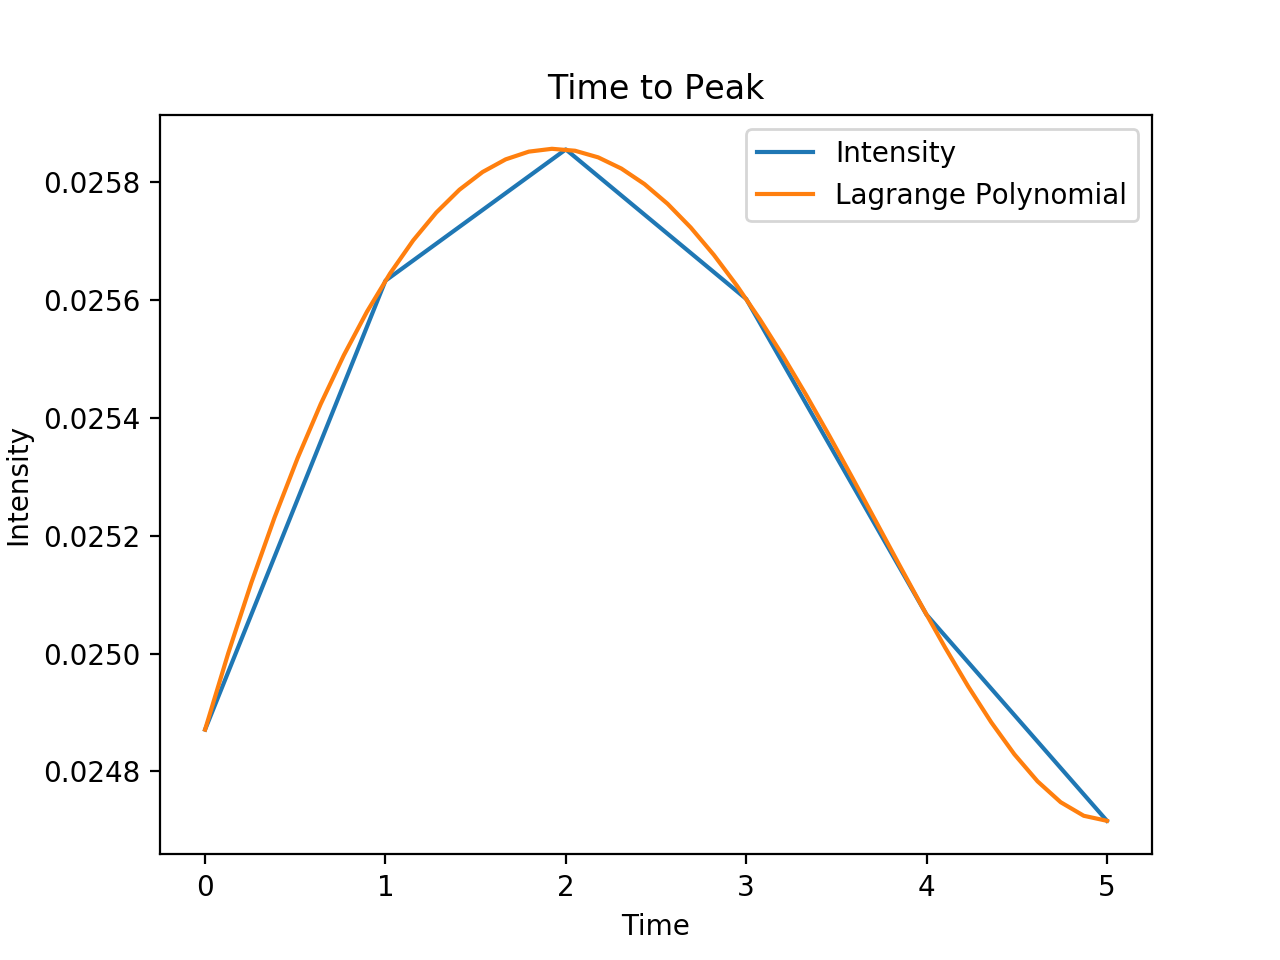

In [11]:
#Plot Time to Peak of bottom right sample
plot_TTP_langrange(intensity_bottom_array)

In [12]:
#Time to peak (x,y) values 
fitted_x, fitted_y = lagrange_curve_fitting(intensity_bottom_array, 30)
max_y = max(fitted_y)
ttp_x = fitted_x[np.argmax(fitted_y)]
print("x value:", ttp_x)
print("y value:", max_y)

x value: 1.896551724137931
y value: 0.025856036518521704


<h1>Lung Mask Voxel Sample<h1>

In [13]:
mask = mat['lung_mask']
mask.shape

(208, 128, 160)

<IPython.core.display.Javascript object>


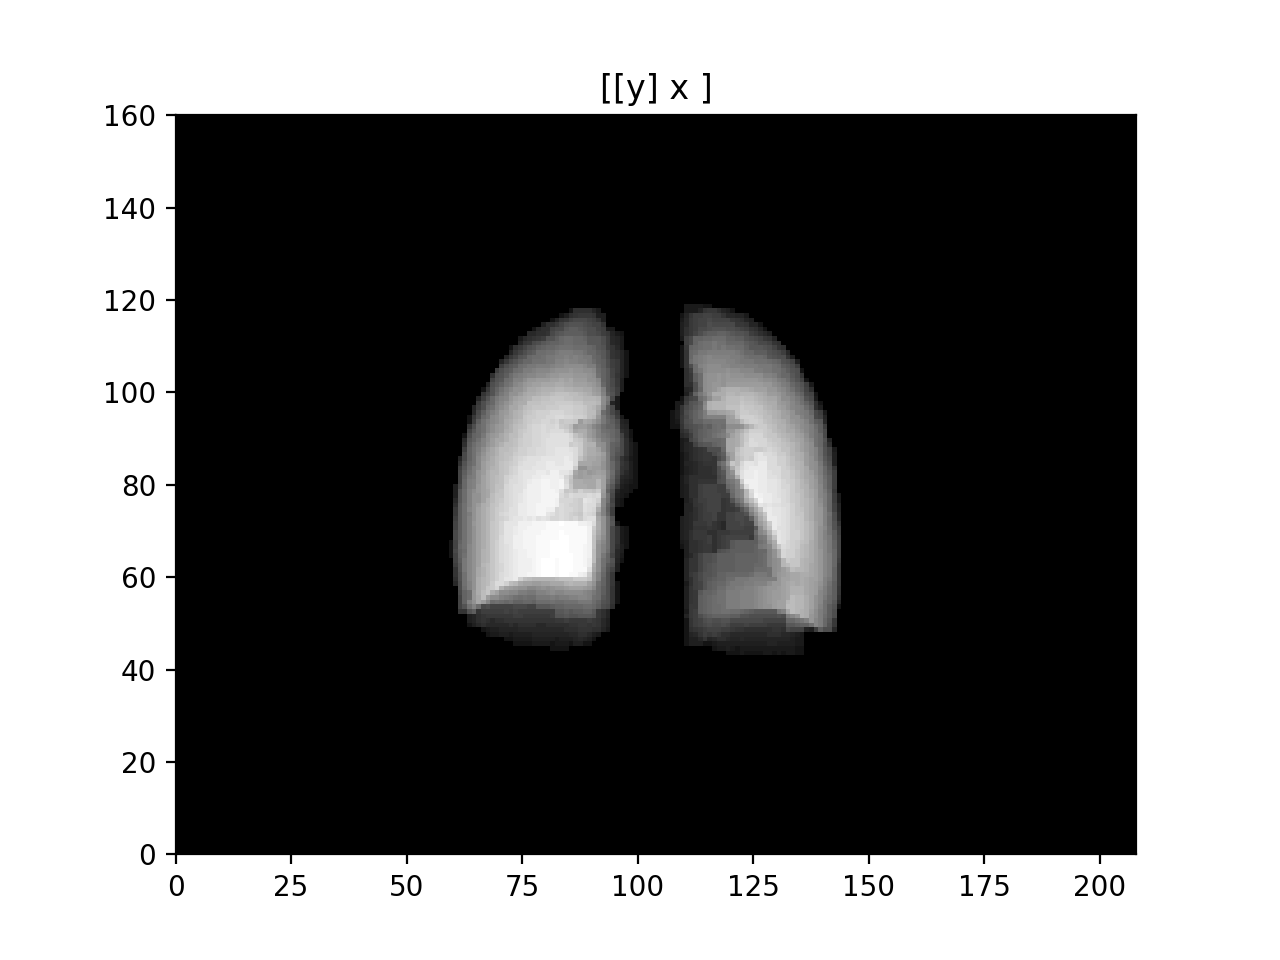

In [14]:
#Plot lung mask image
pl.ImagePlot(np.rot90(np.mean(mask, axis=1), k=3))

<IPython.core.display.Javascript object>


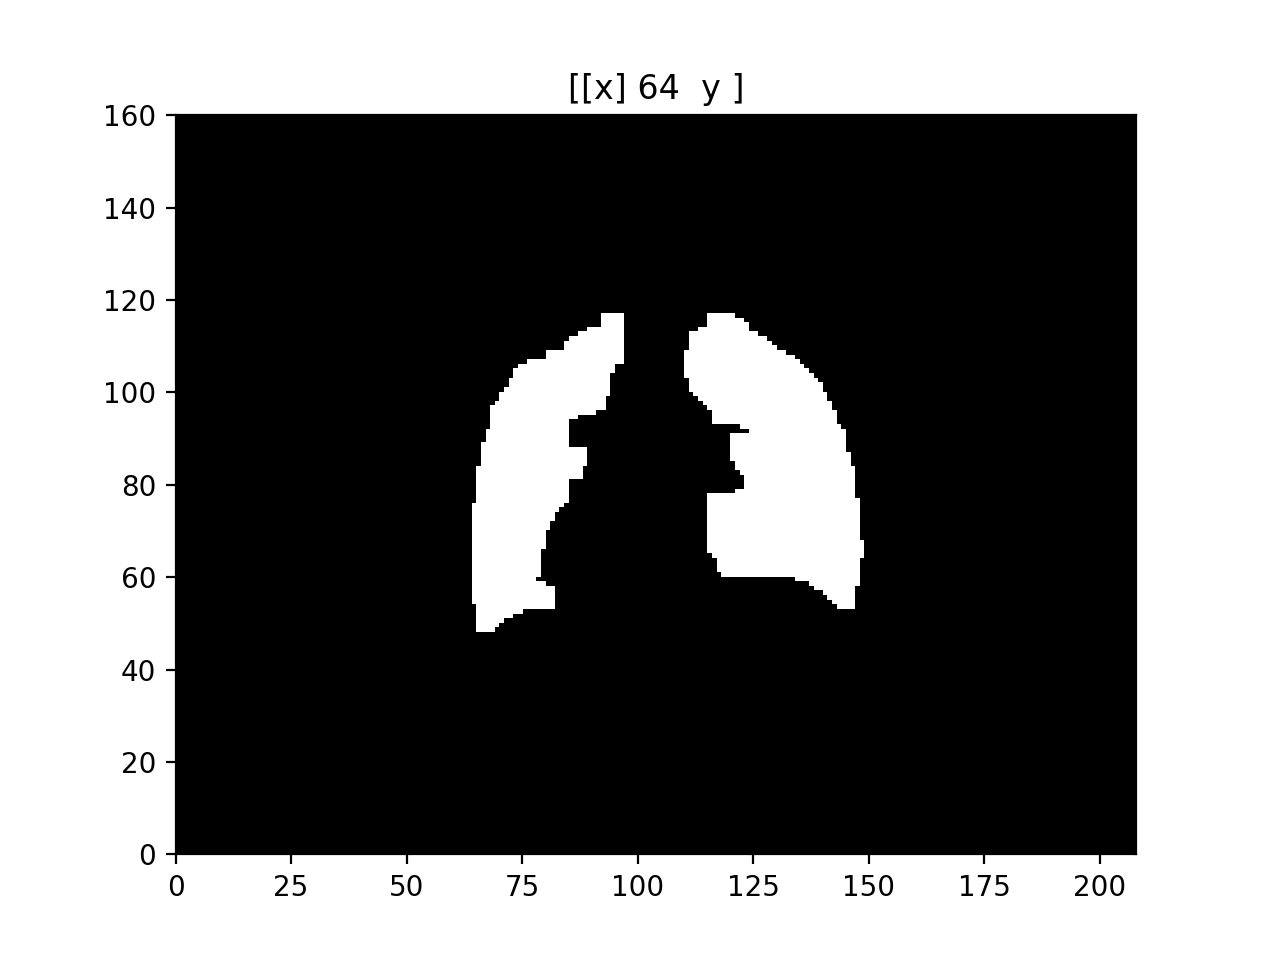

In [15]:
#Plot lung mask image
pl.ImagePlot(mask, x=0, y=2, mode='r')

<IPython.core.display.Javascript object>


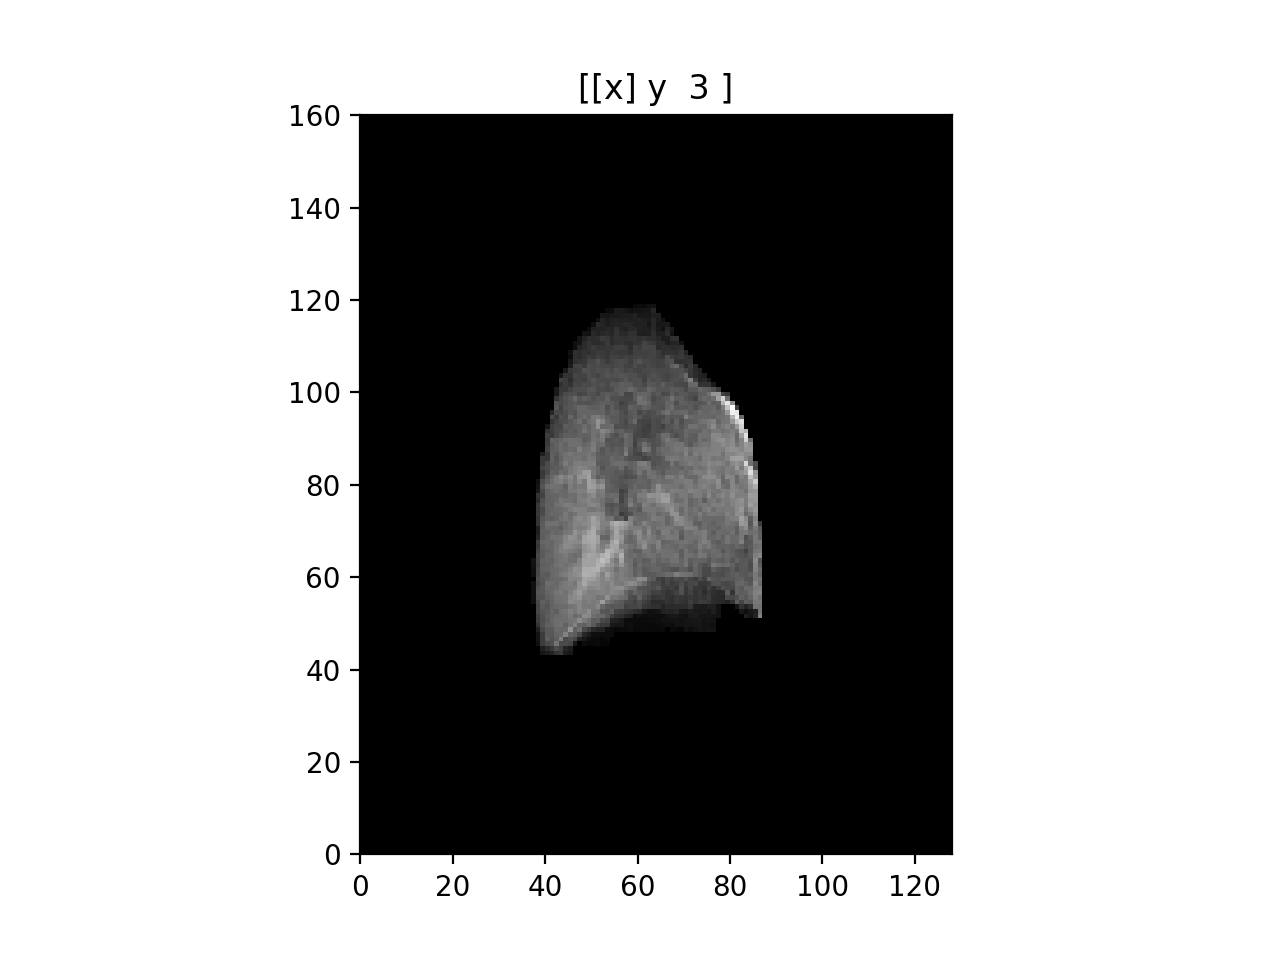

In [16]:
#Multiply lung mask with registered image 
lung_mask = np.empty((208, 128, 160, 6))
for i in range(6):
    lung_mask[:,:,:,i] = np.multiply(registered[:,:,:,i], mask)
pl.ImagePlot(lung_mask.mean(0), x=0)

<IPython.core.display.Javascript object>


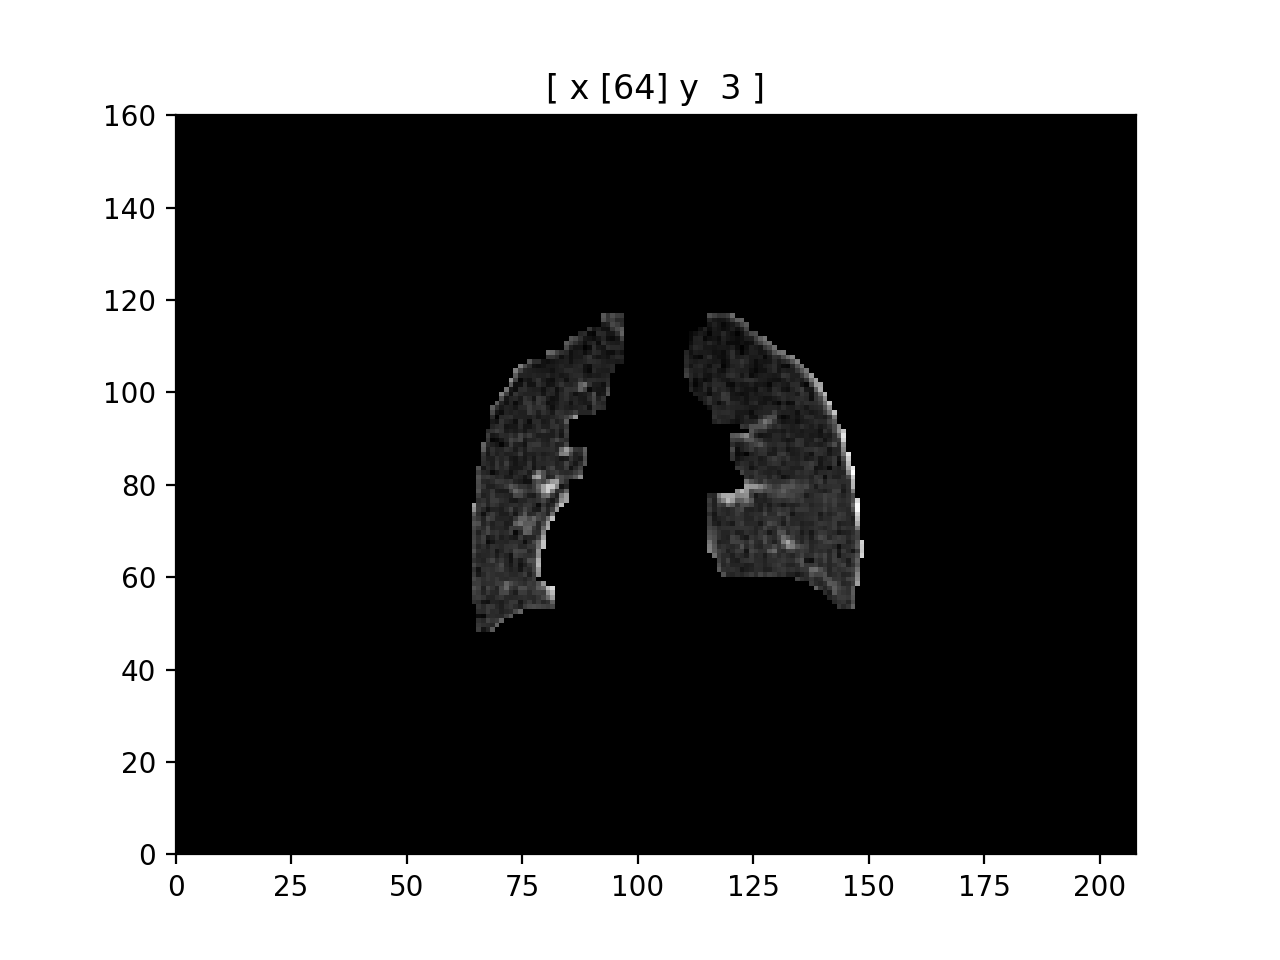

In [17]:
#Plot registered lung mask image
pl.ImagePlot(lung_mask, mode='r', x=0)

In [18]:
lung_mask.shape

(208, 128, 160, 6)

In [19]:
#Generate a voxel sample given a size 
def voxel_sample(img, voxel_size):
    size = voxel_size
    x = img.shape[0] // size
    y = img.shape[1] // size
    z = img.shape[2] // size
    t = img.shape[3]
    sample = np.empty((x,y,z,t))

    for i in range(x):
        for j in range(y):
            for k in range(z):
                for l in range(t):
                    sample[i, j, k, l] = np.mean(img[i*size:(i+1)*size, j*size:(j+1)*size, k*size:(k+1)*size, l:l+1])
    return sample

<IPython.core.display.Javascript object>


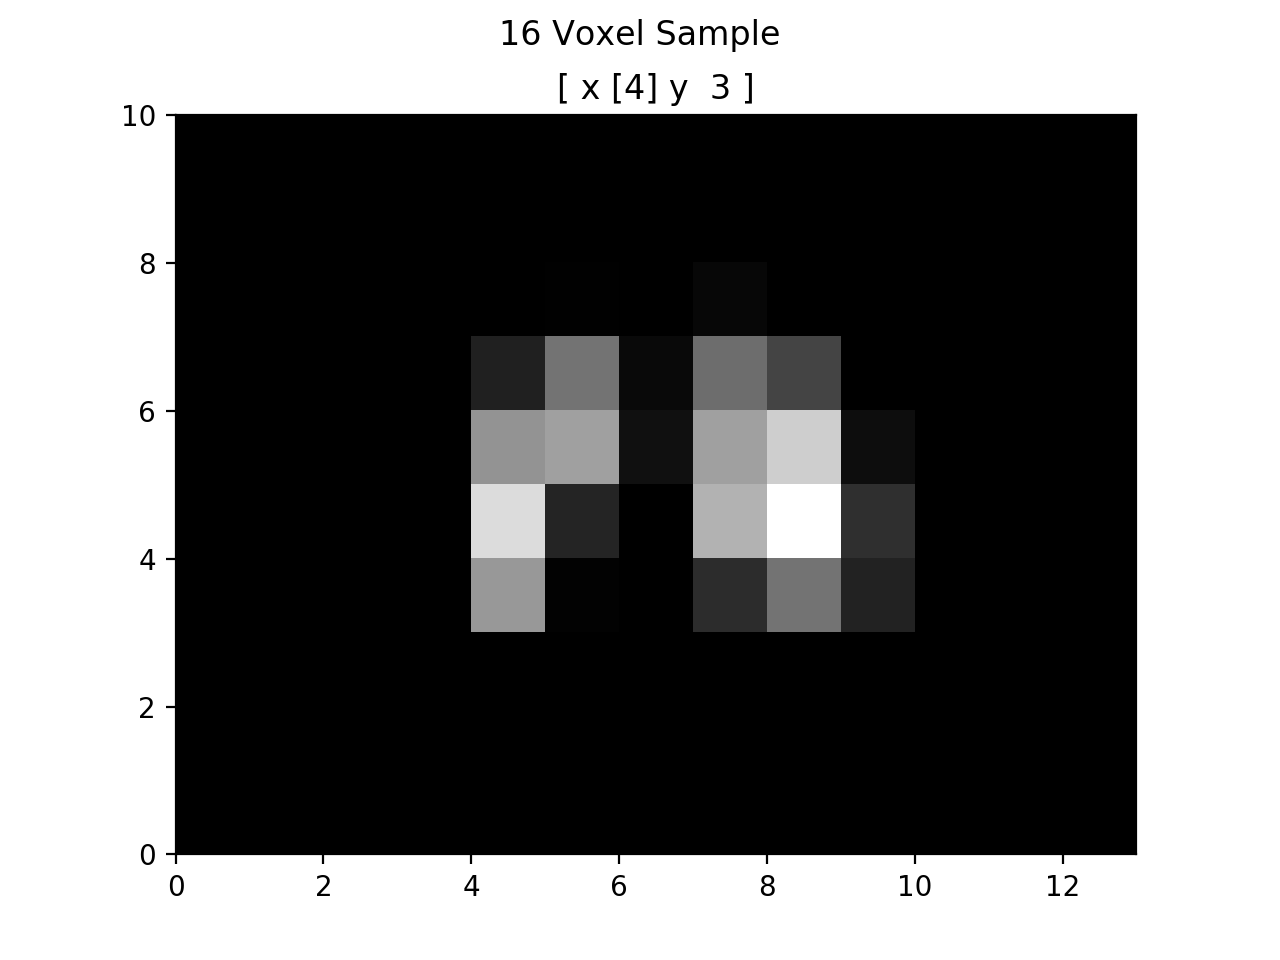

In [20]:
#Plot 16 voxel sample image
intensity_values_16 = voxel_sample(lung_mask, 16)
pl.ImagePlot(intensity_values_16, x=0, title='16 Voxel Sample')

<IPython.core.display.Javascript object>


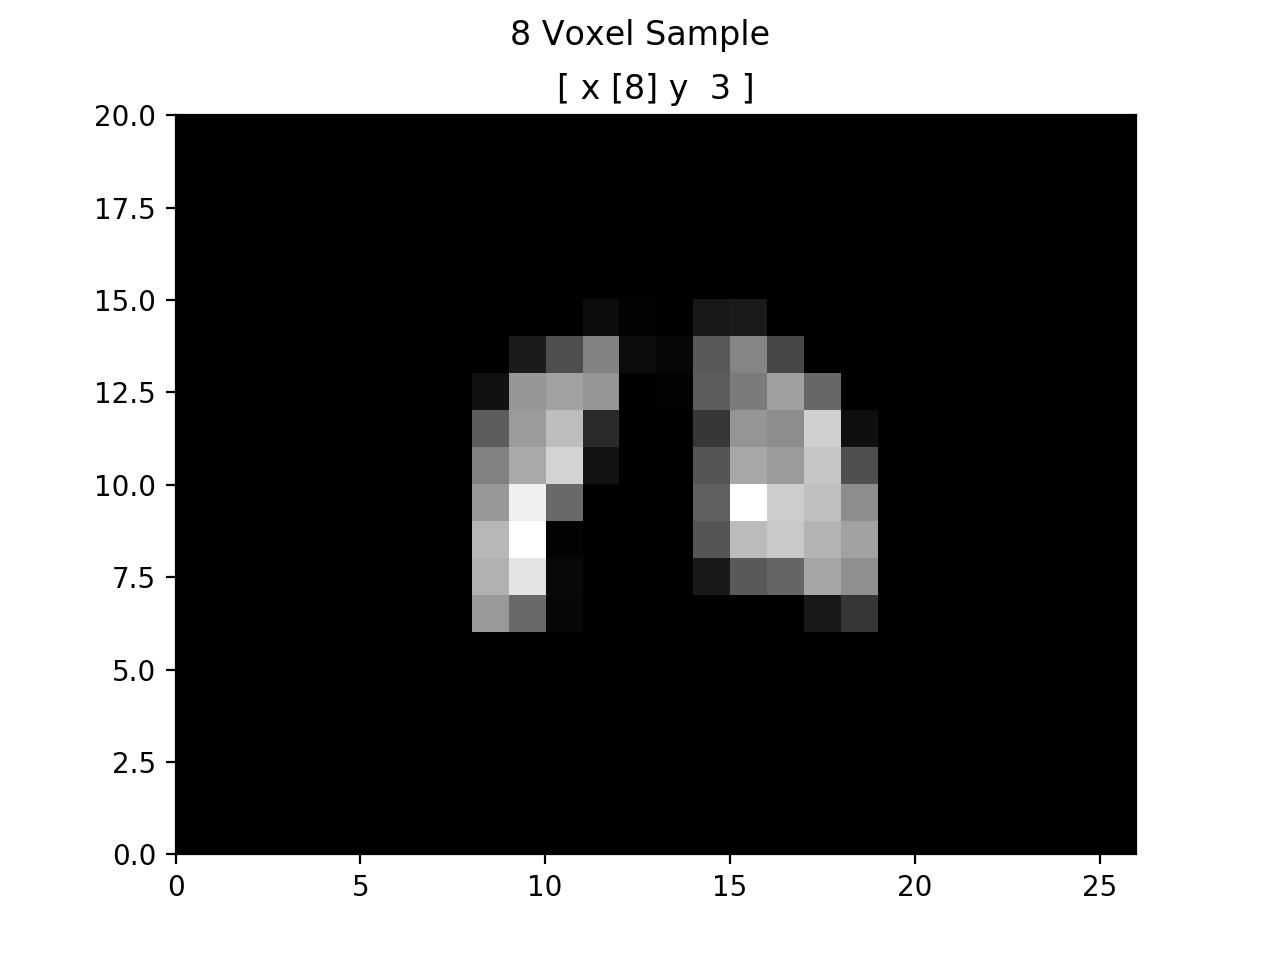

In [21]:
#Plot 8 voxel sample image
intensity_values_8 = voxel_sample(lung_mask, 8)
pl.ImagePlot(intensity_values_8, x=0, title='8 Voxel Sample')

<h1> Color Map <h1>

<IPython.core.display.Javascript object>


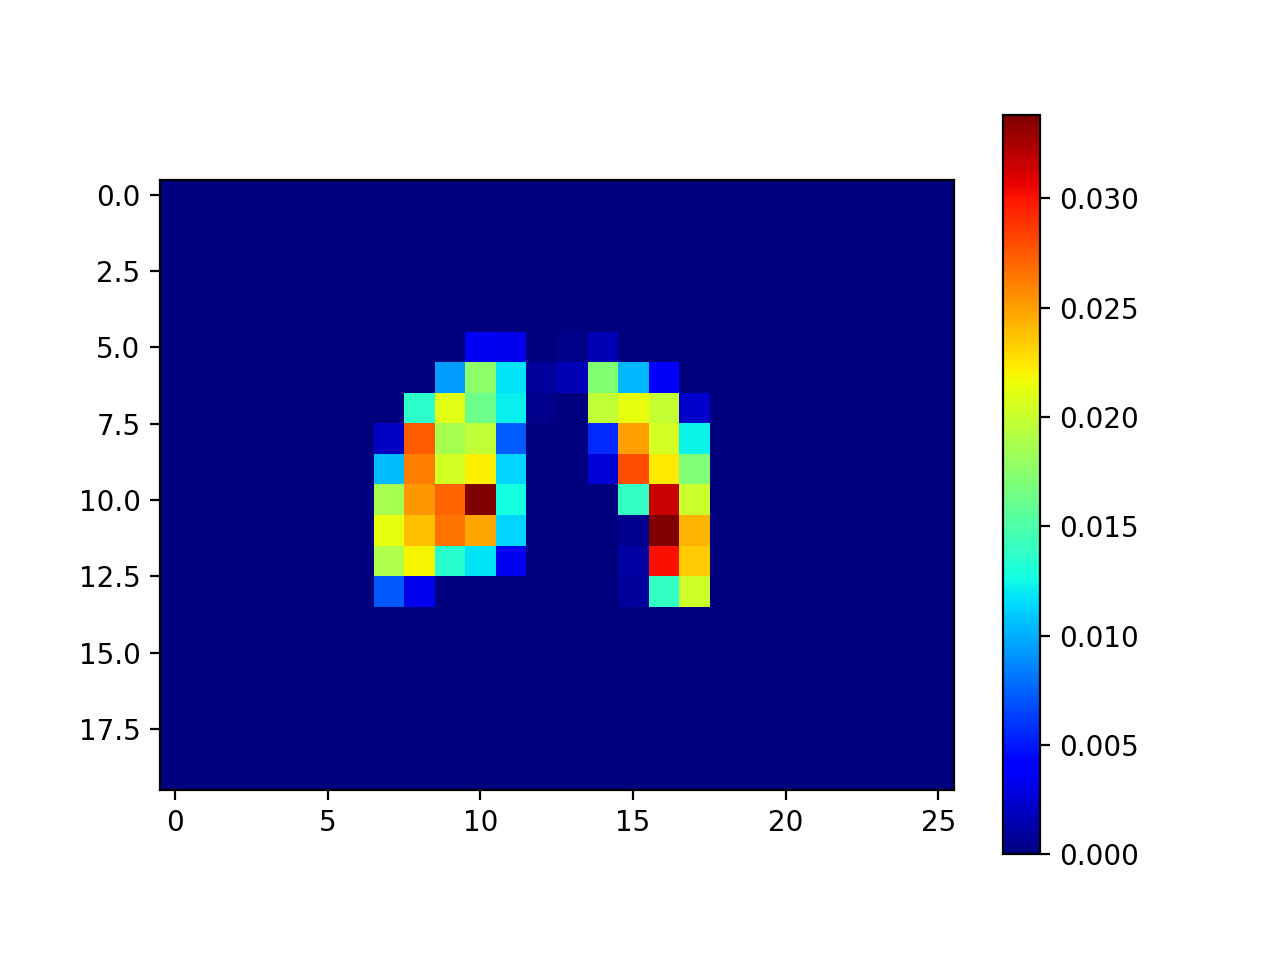

<IPython.core.display.Javascript object>


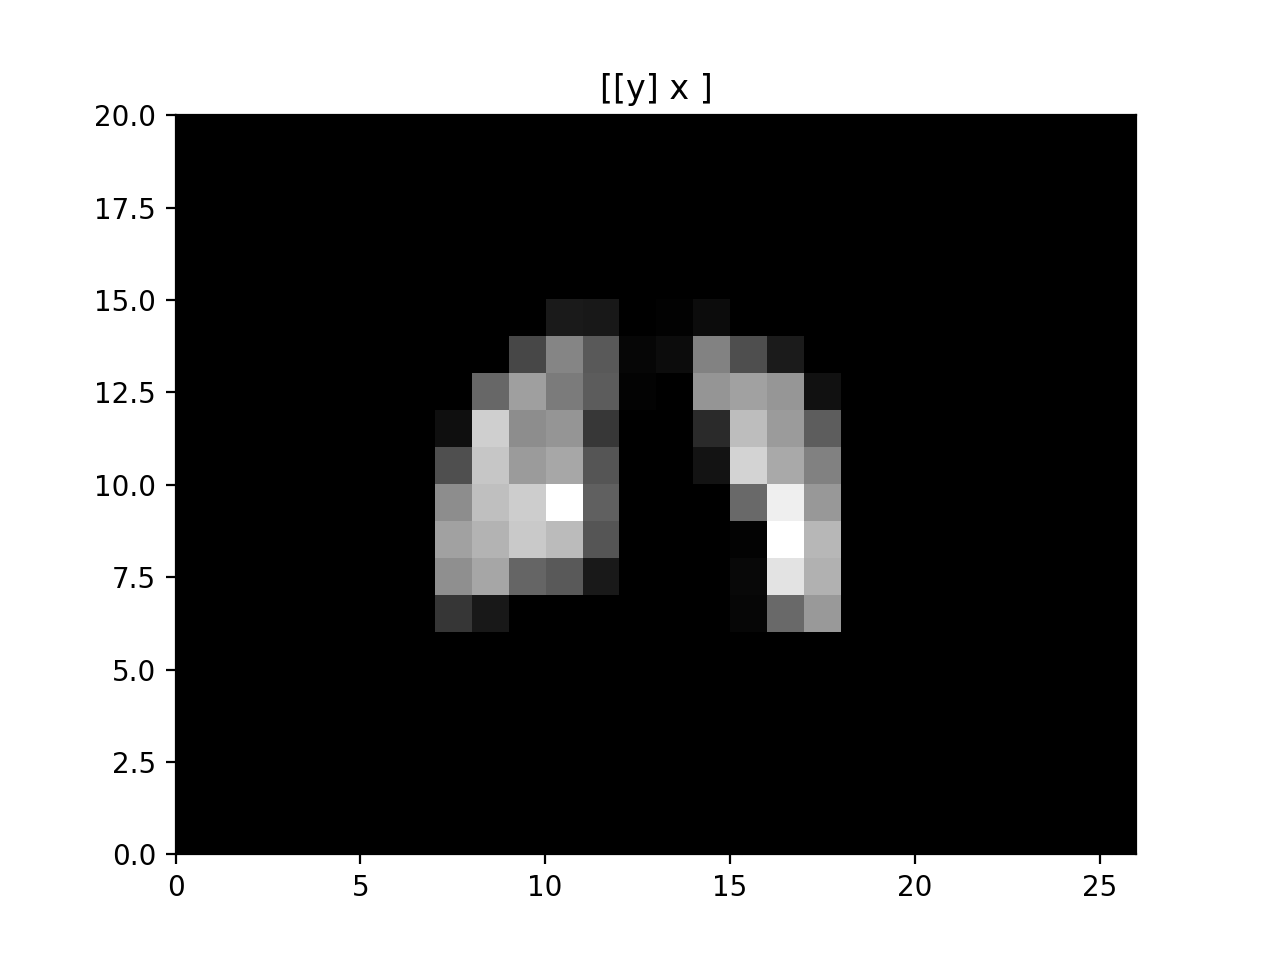

In [22]:
#Use matplotlib to generate colormap, compare to SigPy below
fig = plt.figure()
plt.imshow(np.flip(intensity_values_8[:,8,:,3].T), cmap='jet')
plt.colorbar()

pl.ImagePlot(np.rot90(intensity_values_8[:,8,:,3], k=3))

<IPython.core.display.Javascript object>


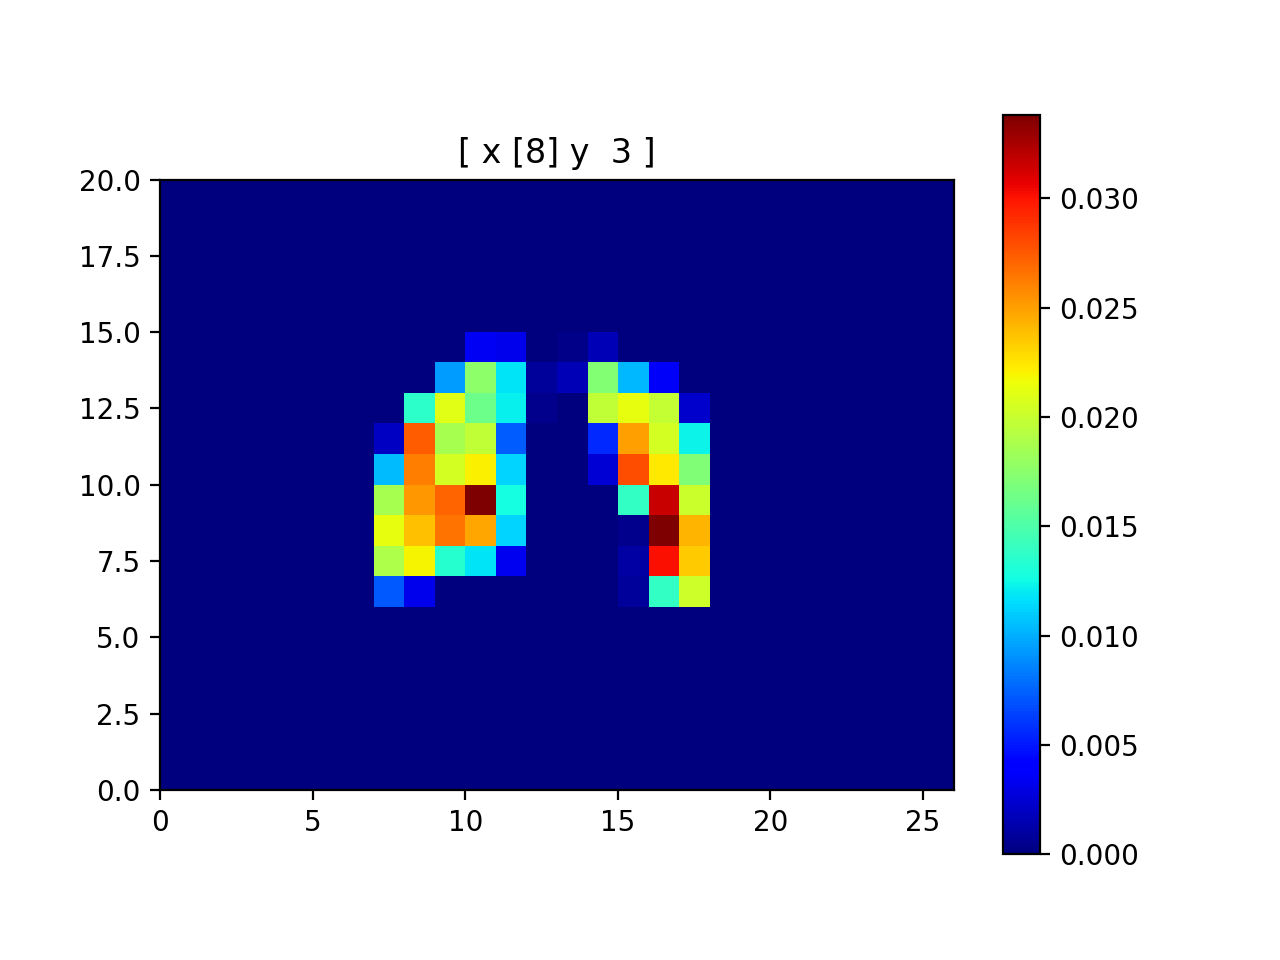

In [23]:
#Using SigPy to plot colormap
pl.ImagePlot(np.flip(intensity_values_8, axis=0), colormap='jet', x=0)

<IPython.core.display.Javascript object>


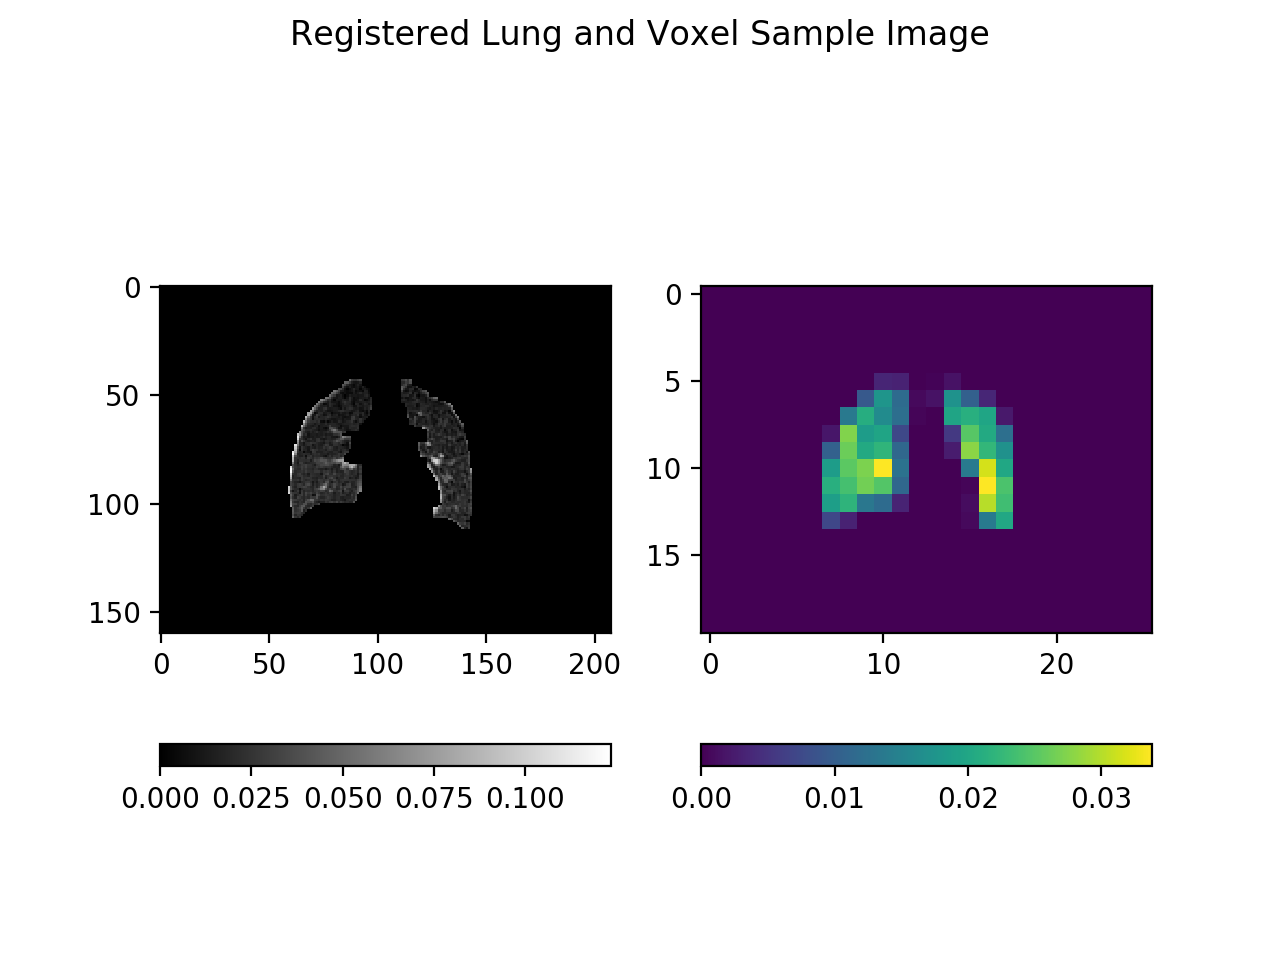

In [24]:
#Horizontally stack plots together
fig, axs = plt.subplots(1, 2)
cm = ['gray', 'viridis']
subplots = [lung_mask[:,64,:,3], intensity_values_8[:,8,:,3]]
fig.suptitle('Registered Lung and Voxel Sample Image')

for col in range(2):
    ax = axs[col]
    pcm = ax.imshow(np.flip(subplots[col].T), cmap=cm[col])
    fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()

<IPython.core.display.Javascript object>


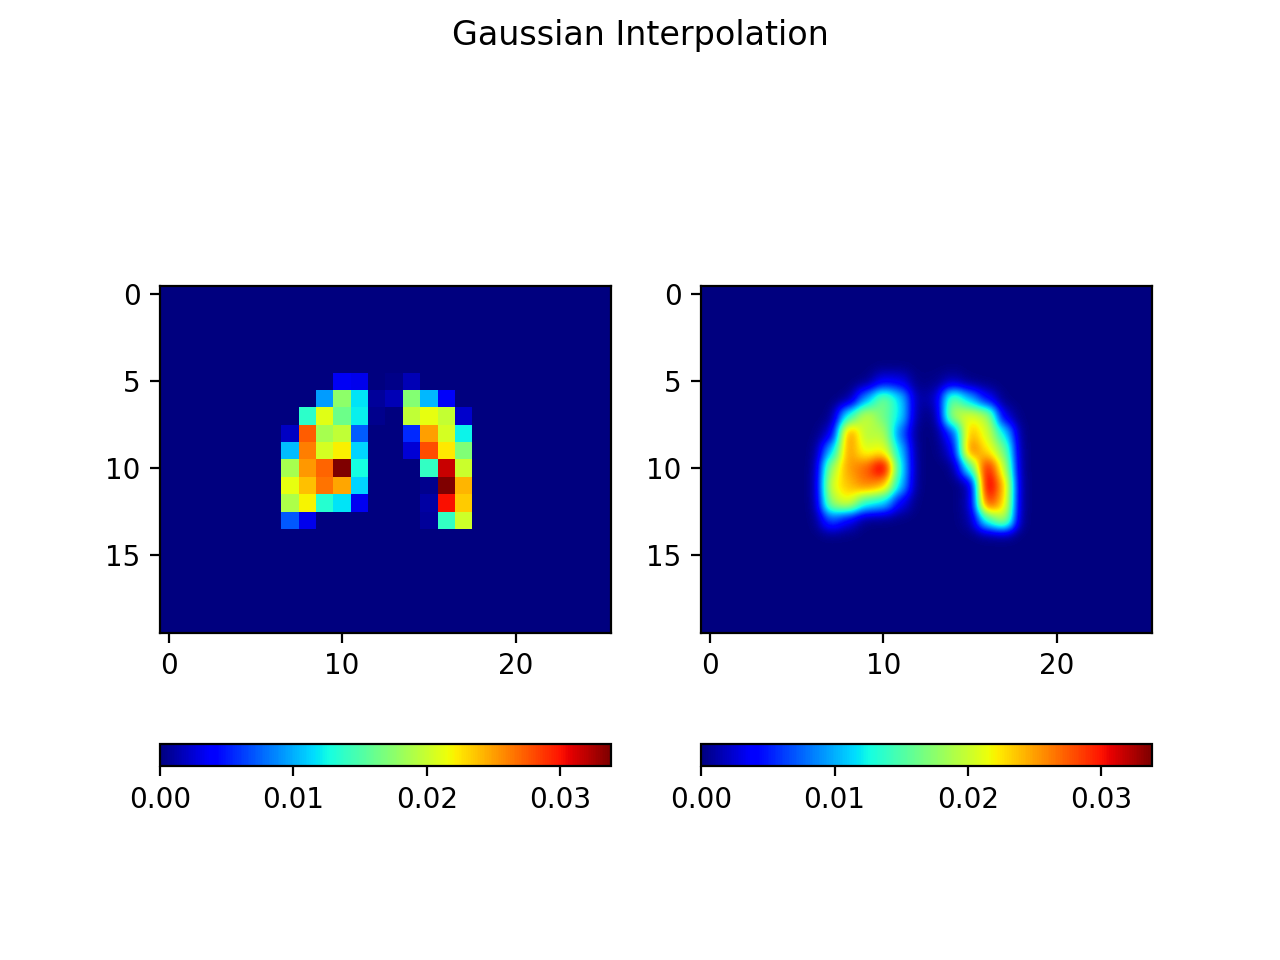

In [25]:
#Gaussian interpolations for imshow()
fig, axs = plt.subplots(1, 2)
subplots = [intensity_values_8[:,8,:,3], intensity_values_8[:,8,:,3]]
interp = [None, 'gaussian']
fig.suptitle('Gaussian Interpolation')

for col in range(2):
    ax = axs[col]
    pcm = ax.imshow(np.flip(subplots[col].T), cmap='jet', interpolation=interp[col])
    fig.colorbar(pcm, ax=ax, orientation='horizontal')
plt.show()

<h1>Time to Peak with Color Map<h1>

Tasks:
1. time to max on x-axis (TTP)
2. max value on y-axis 
3. full width half max (x-axis)

In [26]:
#Computes lagrange polynomial values in [0,5]
def lagrange_curve_fitting(y_values, samples):
    lagrange_x = np.linspace(0,5,6)
    lagrange_y = y_values
    x = np.linspace(0,5,num=samples)
    poly = lagrange(lagrange_x, lagrange_y)
    lagrange_coef = Polynomial(poly).coef
    
    return x, poly(x)

In [27]:
#Calculates peak intensity value 
def peak_intensity(img):
    max_index = np.argmax(img, axis=3)
    sample = np.empty(max_index.shape)
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    
    for i in range(x):
        for j in range(y):
            for k in range(z):
                    indx = max_index[i,j,k]
                    sample[i, j, k] = img[i, j, k, indx]
    return sample

In [28]:
#Calculates time to peak
#See is np.apply_over_axis or np.apply_along_axis can speed it up 
def t_t_p(img):
    x = img.shape[0]
    y = img.shape[1]
    z = img.shape[2]
    sample = np.empty((x,y,z))
    

    for i in range(x):
        for j in range(y):
            for k in range(z):
                    slice_1D = img[i,j,k,:]
                    fitted_x, fitted_y = lagrange_curve_fitting(slice_1D, 20)
                    max_y = max(fitted_y)
                    ttp_x = fitted_x[np.argmax(fitted_y)]
                    sample[i, j, k] = ttp_x
    return sample

<IPython.core.display.Javascript object>


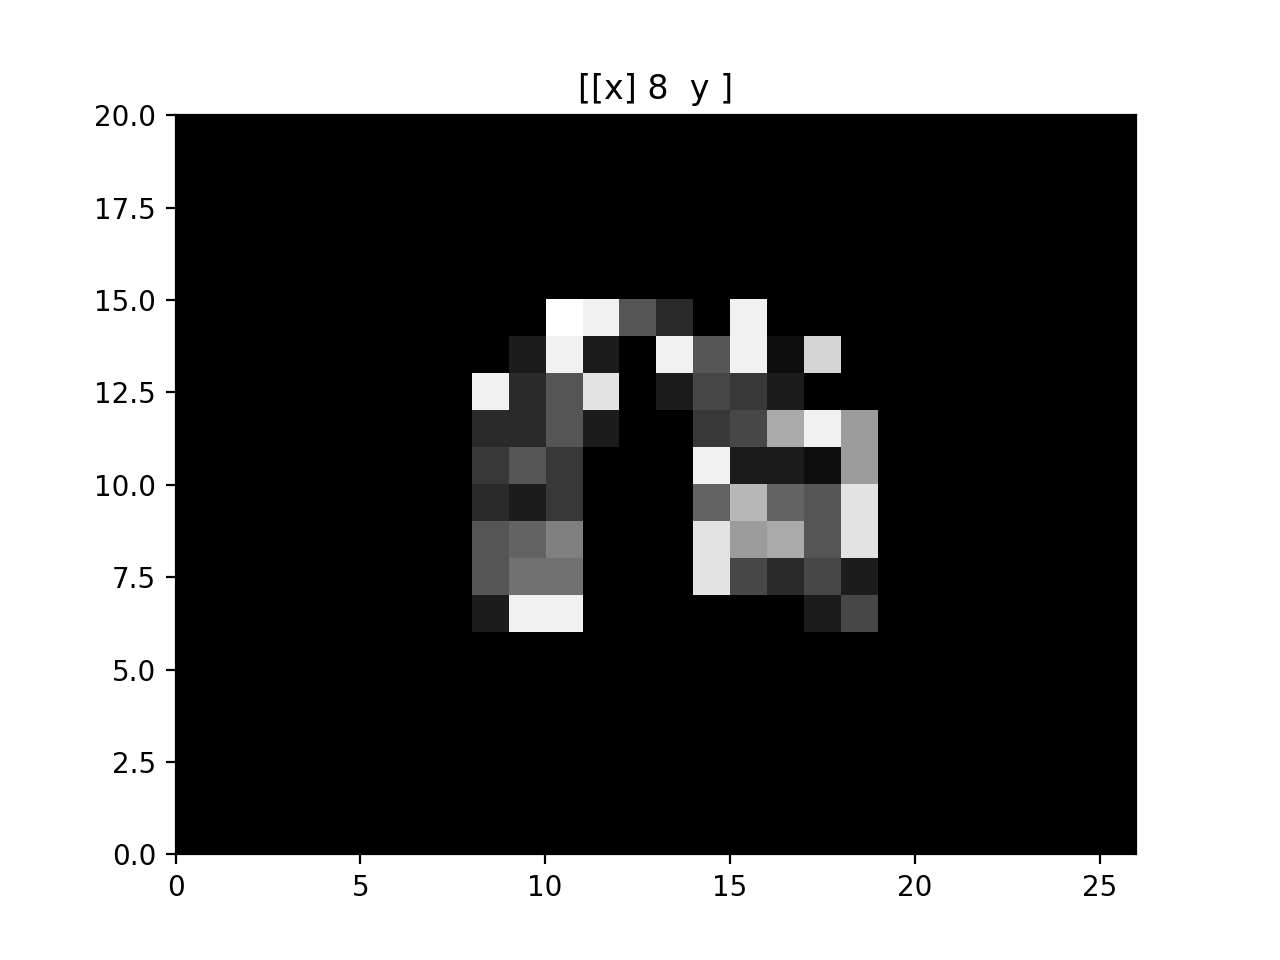

In [29]:
#Plot time to peak 
time_to_peak = t_t_p(intensity_values_8)
pl.ImagePlot(time_to_peak, x=0, y=2)

<IPython.core.display.Javascript object>


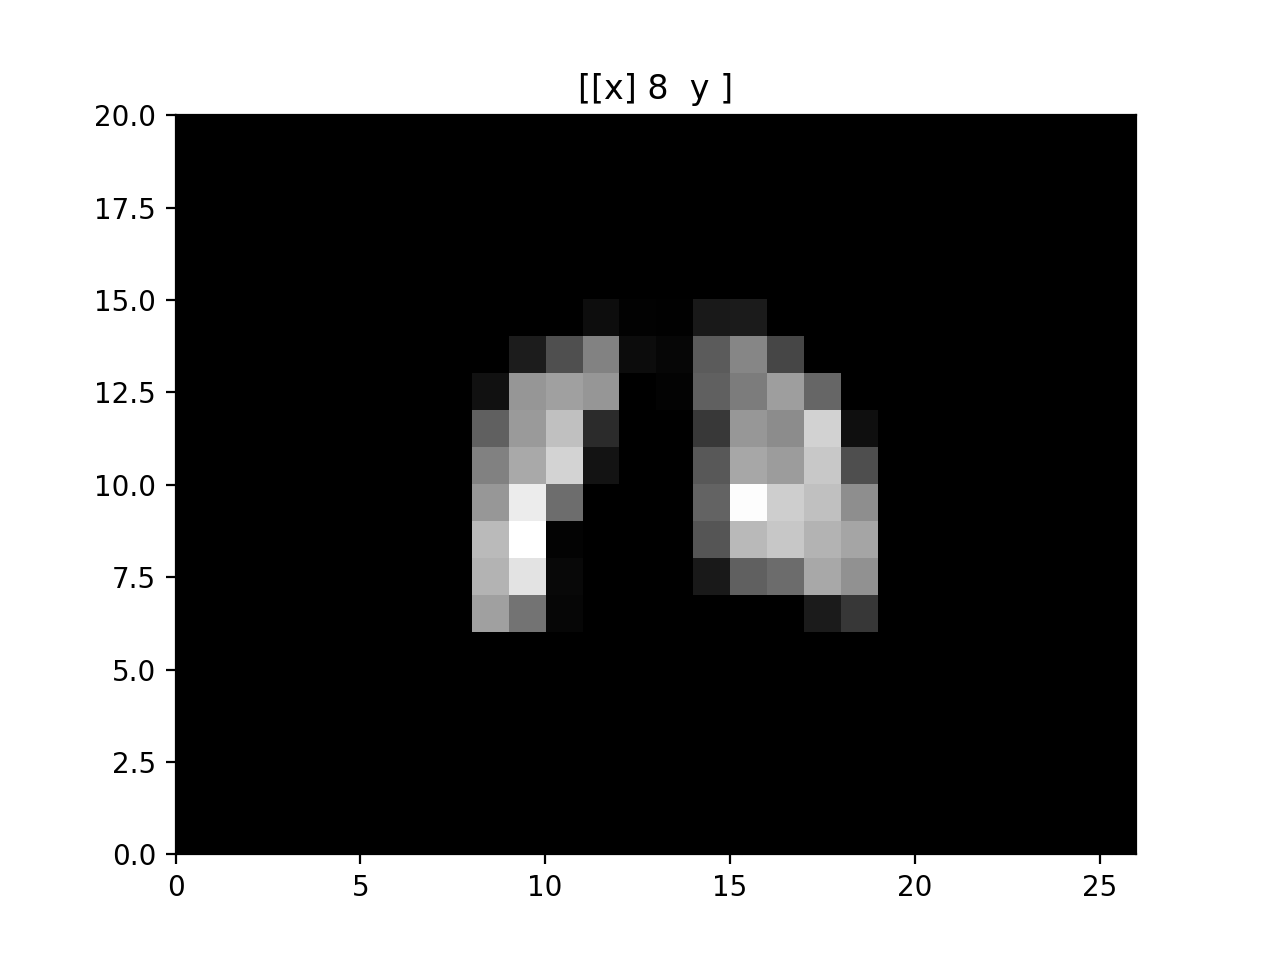

In [30]:
#Plot peak intensity
time_to_peak = peak_intensity(intensity_values_8)
pl.ImagePlot(time_to_peak, x=0, y=2)